<a href="https://colab.research.google.com/github/rajeshmore1/DataScience_Mentorship/blob/main/NLP_4_Topic_Modeling_with_LDA(Extra_Material).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#<b> What is Topic Modeling ?</b>


### In natural language understanding (NLU) tasks, there is a hierarchy of lenses through which we can extract meaning — from words to sentences to paragraphs to documents. At the document level, one of the most useful ways to understand text is by analyzing its topics. The process of learning, recognizing, and extracting these topics across a collection of documents is called topic modeling.

### Topic modelling refers to the task of identifying topics that best describes a set of documents. These topics will only emerge during the topic modelling process (therefore called latent). And one popular topic modeling technique is known as Latent Dirichlet Allocation (LDA).

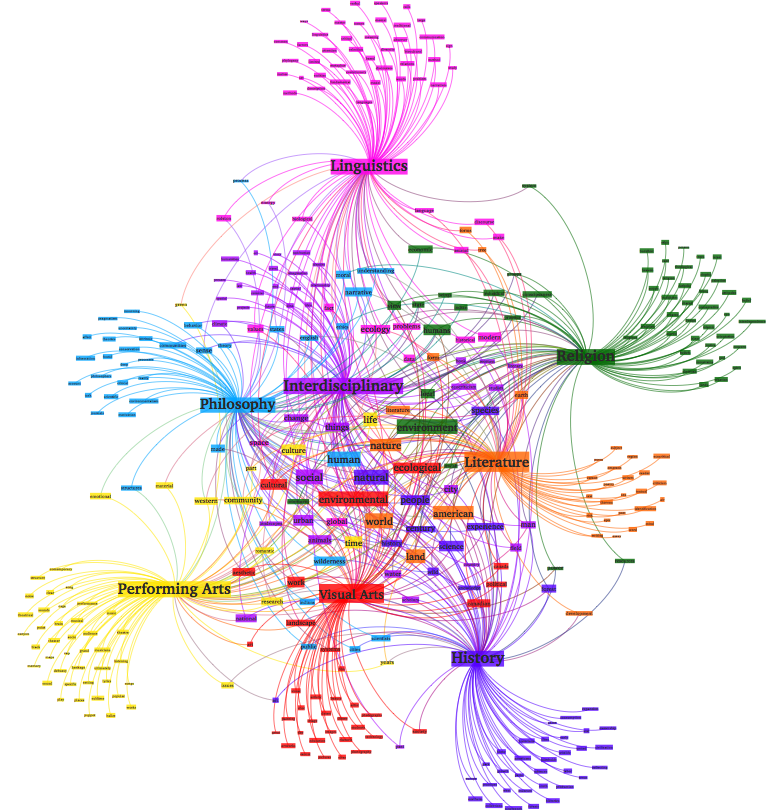

## All topic models are based on the same basic assumption:
* ### each document consists of a mixture of topics, and
* ### each topic consists of a collection of words.

### In other words, topic models are built around the idea that the semantics of our document are actually being governed by some hidden, or “latent,” variables that we are not observing. As a result, the goal of topic modeling is to uncover these latent variables — topics — that shape the meaning of our document and corpus.

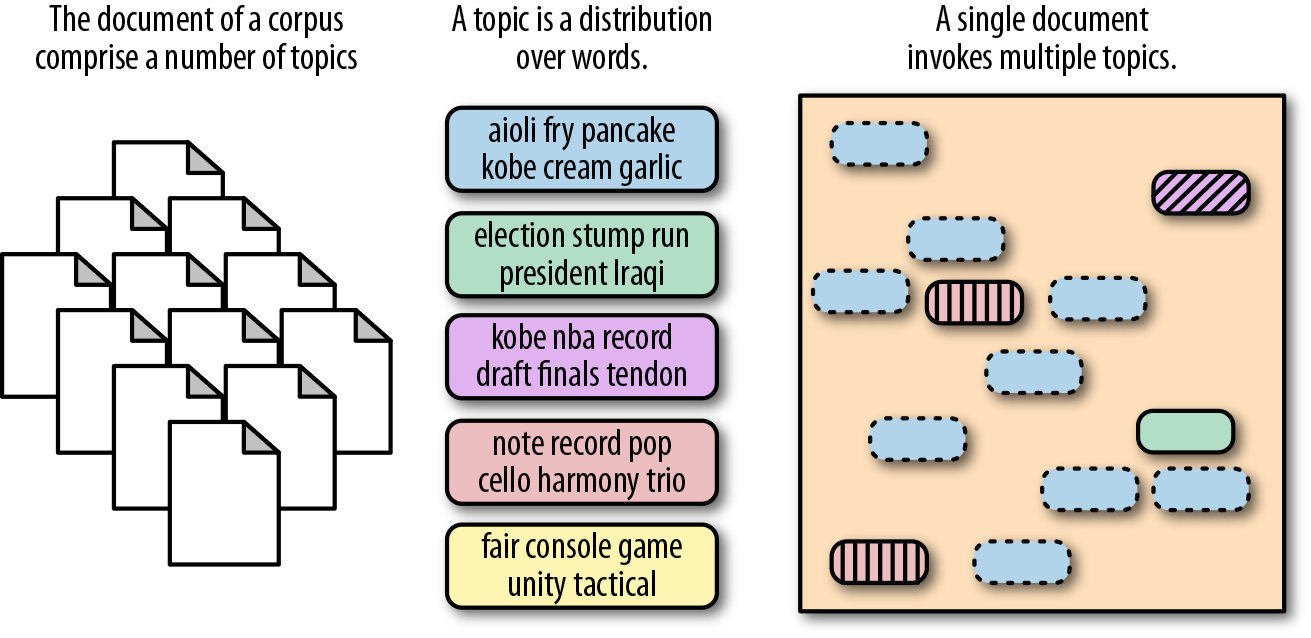

## <b><u> Exploratory Data Analysis </u></b>
### As usual, it is prudent to begin with some basic exploratory analysis.

In [ ]:
import numpy as np
import pandas as pd
from IPython.display import display
from tqdm import tqdm
from collections import Counter
import ast

import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
import seaborn as sb

from sklearn.feature_extraction.text import CountVectorizer
from textblob import TextBlob
import scipy.stats as stats

from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.manifold import TSNE

output_notebook()

%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
datafile = '/content/drive/MyDrive/AlmaBetter/Cohort Aravali/Module 4/Week 3/Day 6/abcnews-date-text.csv'
raw_data = pd.read_csv(datafile, parse_dates=[0], infer_datetime_format=True)

reindexed_data = raw_data['headline_text']
reindexed_data.index = raw_data['publish_date']

raw_data.head()

,publish_date,headline_text
0,2003-02-19,aba decides against community broadcasting lic...
1,2003-02-19,act fire witnesses must be aware of defamation
2,2003-02-19,a g calls for infrastructure protection summit
3,2003-02-19,air nz staff in aust strike for pay rise
4,2003-02-19,air nz strike to affect australian travellers


### First we develop a list of the top words used across all one million headlines, giving us a glimpse into the core vocabulary of the source data. Stop words are omitted here to avoid any trivial conjunctions, prepositions, etc.

In [ ]:
# Define helper functions
def get_top_n_words(n_top_words, count_vectorizer, text_data):
    '''
    returns a tuple of the top n words in a sample and their 
    accompanying counts, given a CountVectorizer object and text sample
    '''
    vectorized_headlines = count_vectorizer.fit_transform(text_data.values)
    vectorized_total = np.sum(vectorized_headlines, axis=0)
    word_indices = np.flip(np.argsort(vectorized_total)[0,:], 1)
    word_values = np.flip(np.sort(vectorized_total)[0,:],1)
    
    word_vectors = np.zeros((n_top_words, vectorized_headlines.shape[1]))
    for i in range(n_top_words):
        word_vectors[i,word_indices[0,i]] = 1

    words = [word[0].encode('ascii').decode('utf-8') for 
             word in count_vectorizer.inverse_transform(word_vectors)]

    return (words, word_values[0,:n_top_words].tolist()[0])

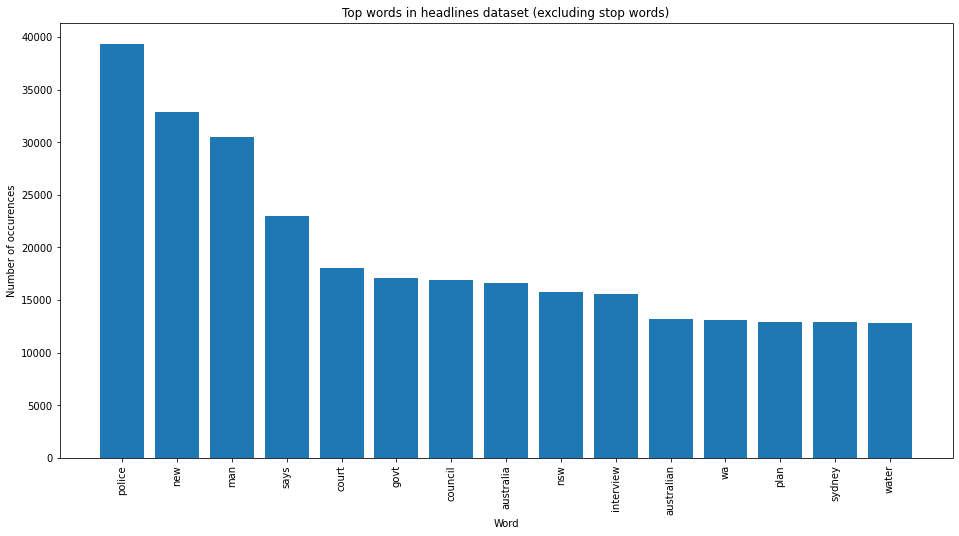

In [ ]:
count_vectorizer = CountVectorizer(stop_words='english')
words, word_values = get_top_n_words(n_top_words=15,
                                     count_vectorizer=count_vectorizer, 
                                     text_data=reindexed_data)

fig, ax = plt.subplots(figsize=(16,8))
ax.bar(range(len(words)), word_values)
ax.set_xticks(range(len(words)))
ax.set_xticklabels(words, rotation='vertical')
ax.set_title('Top words in headlines dataset (excluding stop words)')
ax.set_xlabel('Word')
ax.set_ylabel('Number of occurences')
plt.show()

## <b> Topic Modelling </b>

### We now apply a clustering algorithm to the headlines corpus in order to study the topic focus of ABC News, as well as how it has evolved through time. To do so, we first experiment with a small subsample of the dataset in order to determine which of the two potential clustering algorithms is most appropriate – once this has been ascertained, we can then scale up to a larger portion of the available data.

## <b>Preprocessing</b>


### The only preprocessing step required in our case is feature construction, where we take the sample of text headlines and represent them in some tractable feature space. In practice, this simply means converting each string to a numerical vector. This can be done using the ```CountVectorizer``` object from SKLearn, which yields an $n×K$ document-term matrix where $K$ is the number of distinct words  across the $n$ headlines in our sample (less stop words and with a limit of ```max_features```).

In [ ]:
small_count_vectorizer = CountVectorizer(stop_words='english', max_features=4000)
small_text_sample = reindexed_data.sample(n=10000, random_state=0).values

print('Headline before vectorization: {}'.format(small_text_sample[123]))

small_document_term_matrix = small_count_vectorizer.fit_transform(small_text_sample)

print('Headline after vectorization: \n{}'.format(small_document_term_matrix[123]))

Headline before vectorization: man jailed for theft of police files
Headline after vectorization: 
  (0, 2196)	1
  (0, 2662)	1
  (0, 1917)	1
  (0, 3596)	1


### Thus we have our (very high-rank and sparse) training data,  ```small_document_term_matrix```, and can now actually implement a clustering algorithm. Our choice will be Latent Dirichlet Allocation. IT  will take our document-term matrix as input and yield an $n \times N$ topic matrix as output, where $N$ is the number of topic categories (which we supply as a parameter).

## <b>Latent Dirichlet Allocation</b>

### LDA is a generative probabilistic process, designed with the specific goal of uncovering latent topic structure in text corpora.

In [ ]:
# Parameters tuning using Grid Search
from sklearn.model_selection import GridSearchCV
grid_params = {'n_components' : list(range(5,10))}

# LDA model
lda = LatentDirichletAllocation()
lda_model = GridSearchCV(lda,param_grid=grid_params)
lda_model.fit(small_document_term_matrix)

# Best LDA model
best_lda_model = lda_model.best_estimator_

print("Best LDA model's params" , lda_model.best_params_)
print("Best log likelihood Score for the LDA model",lda_model.best_score_)
print("LDA model Perplexity on train data", best_lda_model.perplexity(small_document_term_matrix))

Best LDA model's params {'n_components': 5}
Best log likelihood Score for the LDA model -82895.33081684374
LDA model Perplexity on train data 3890.5324761734973


### Once again, we take the $\arg \max$ of each entry in the topic matrix to obtain the predicted topic category for each headline. These topic categories can then be characterised by their most frequent words.


In [ ]:
!pip install pyLDAvis

In [ ]:
import pyLDAvis.sklearn

pyLDAvis.enable_notebook()

In [ ]:
lda_panel = pyLDAvis.sklearn.prepare(best_lda_model, small_document_term_matrix,small_count_vectorizer,mds='tsne')
lda_panel

PreparedData(topic_coordinates=                x           y  topics  cluster       Freq
topic                                                    
4      150.222153  -72.269554       1        1  21.811117
1       51.163364 -159.968018       2        1  20.997240
3      -73.144554   21.523815       3        1  20.214062
2      -66.410133 -110.606438       4        1  18.717531
0       54.417324   12.443444       5        1  18.260051, topic_info=           Term        Freq       Total Category  logprob  loglift
2196        man  227.000000  227.000000  Default  30.0000  30.0000
2662     police  302.000000  302.000000  Default  29.0000  29.0000
1872  interview  106.000000  106.000000  Default  28.0000  28.0000
2411        new  244.000000  244.000000  Default  27.0000  27.0000
2629       plan  104.000000  104.000000  Default  26.0000  26.0000
...         ...         ...         ...      ...      ...      ...
1993     killed   25.697768   72.744875   Topic5  -5.6827   0.6599
717       china   23.918239   55.032924   Topic5  -5.7544   0.8672
3129       says   27.331715  167.300575   Topic5  -5.6210  -0.1113
2803        qld   24.173329   97.621155   Topic5  -5.7438   0.3046
1736        hit   23.514158   49.258172   Topic5  -5.7715   0.9610

[293 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
61        1  0.163173         abc
61        2  0.652693         abc
61        3  0.183570         abc
63        2  0.959740  aboriginal
72        5  0.958652    accident
...     ...       ...         ...
3971      1  0.917897       world
3971      4  0.072849       world
3988      3  0.762412       years
3988      4  0.226663       years
3993      2  0.968328       young

[427 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[5, 2, 4, 3, 1])

# <b><u> How LDA works? </u></b>

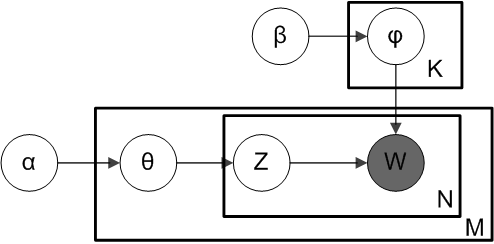

### From a dirichlet distribution $Dir(α)$, we draw a random sample representing the topic distribution, or topic mixture, of a particular document. This topic distribution is $θ$. From $θ$, we select a particular topic $Z$ based on the distribution.


### Next, from another dirichlet distribution $Dir(𝛽)$, we select a random sample representing the word distribution of the topic $Z$. This word distribution is $φ$. From $φ$, we choose the word $w$.

### The normal distribution is a probability distribution over all the real numbers. It is described by a mean and a variance. The mean is the expected value of this distribution, and the variance tells us how much we can expect samples to deviate from the mean. If the variance is very high, then you’re going to see values that are both much smaller than the mean and much larger than the mean. If the variance is small, then the samples will be very close to the mean. If the variance goes close to zero, all samples will be almost exactly at the mean.

### Similarly, the dirichlet distribution is a probability distribution as well - but it is not sampling from the space of real numbers. Instead it is sampling over a probability simplex.

### And what is a probability simplex? It’s a bunch of numbers that add up to 1. For example:

* ### (0.6, 0.4)
* ### (0.1, 0.1, 0.8)
* ### (0.05, 0.2, 0.15, 0.1, 0.3, 0.2)

### These numbers represent probabilities over K distinct categories. In the above examples, K is 2, 3, and 6 respectively. 